# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import resample
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score

from collections import Counter
from scipy.stats import randint

import plotly.express as px

#LSTM
from sklearn.model_selection import train_test_split
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
def get_sentence_word_count(text_list):
    '''
    It will calculate the total number of sentences and unique words present in the transcription data.
    Parameters : 
    text_list : Transcription Data of type list
    Returns : 
    sen_count : Number of sentences in the data
    word_count : Number of unique words present in the data
    '''
    sent_count = 0

    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [3]:
#Reading our csv file
clinical_text_df = pd.read_csv("/content/mtsamples.csv")
clinical_text_df['medical_specialty']

0              Allergy / Immunology
1                        Bariatrics
2                        Bariatrics
3        Cardiovascular / Pulmonary
4        Cardiovascular / Pulmonary
                   ...             
4994           Allergy / Immunology
4995           Allergy / Immunology
4996           Allergy / Immunology
4997           Allergy / Immunology
4998           Allergy / Immunology
Name: medical_specialty, Length: 4999, dtype: object

In [4]:
clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))


Number of sentences in transcriptions column: 140235
Number of unique words in transcriptions column: 35805


In [5]:
print("Number of documents in each categories in the decreasing order")
df=pd.DataFrame(clinical_text_df['medical_specialty'].value_counts())
df.index.name="Medical Specialty"
df.reset_index(inplace=True)
df=df.rename({'medical_specialty':'Counts'},axis=1)
df

Number of documents in each categories in the decreasing order


,Medical Specialty,Counts
0,Surgery,1088
1,Consult - History and Phy.,516
2,Cardiovascular / Pulmonary,371
3,Orthopedic,355
4,Radiology,273
5,General Medicine,259
6,Gastroenterology,224
7,Neurology,223
8,SOAP / Chart / Progress Notes,166
9,Urology,156


In [6]:
#Creating a dictionary with key being the category and the value being None for now.
specialty_dict={}
for i in df['Medical Specialty']:
  specialty_dict[i] = 'None'


##Manually combining the categories


In [7]:

#Since many categories don't have sufficient records in it, we then tried to combine some categories together which were similar.
specialty_dict[' Consult - History and Phy.']='Report/Exam Type'
specialty_dict[' Emergency Room Reports']='Report/Exam Type'
specialty_dict[' Discharge Summary']='Report/Exam Type'
specialty_dict[' IME-QME-Work Comp etc.']='Report/Exam Type'
specialty_dict[' Letters']='Report/Exam Type'
specialty_dict[' Office Notes']='Report/Exam Type'
specialty_dict[' SOAP / Chart / Progress Notes']='Report/Exam Type'
specialty_dict[' Autopsy']='Report/Exam Type'
specialty_dict[' Orthopedic']='Bone/Joint Problem Type'
specialty_dict[' Podiatry']='Bone/Joint Problem Type'
specialty_dict[' Neurology']='Neurology'
specialty_dict[' Neurosurgery']='Neurology'
specialty_dict[' Radiology']='Lab Type'
specialty_dict[' Lab Medicine - Pathology']='Lab Type'
specialty_dict[' Sleep Medicine']='General Medicine'
specialty_dict[' General Medicine']='General Medicine'
specialty_dict[' Urology']='Kidney Issue Type'
specialty_dict[' Nephrology']='Kidney Issue Type'
specialty_dict[' Pain Management']='Patient Care'
specialty_dict[' Hospice - Palliative Care']='Patient Care'
specialty_dict[' Psychiatry / Psychology']='Behaviour Type'
specialty_dict[' Speech - Language']='Behaviour Type'
specialty_dict[' Dermatology']='Hair/Skin Type'
specialty_dict[' Cosmetic / Plastic Surgery']='Hair/Skin Type'
specialty_dict[' Physical Medicine - Rehab']='Physical Therapy'
specialty_dict[' Chiropractic']='Physical Therapy'
specialty_dict[' Bariatrics']='Weight Loss Type'
specialty_dict[' Diets and Nutritions']='Weight Loss Type'
specialty_dict[' Allergy / Immunology']='Specialties in Immunology'
specialty_dict[' Rheumatology']='Specialties in Immunology'

In [8]:
specialty_dict

{' Surgery': 'None',
 ' Consult - History and Phy.': 'Report/Exam Type',
 ' Cardiovascular / Pulmonary': 'None',
 ' Orthopedic': 'Bone/Joint Problem Type',
 ' Radiology': 'Lab Type',
 ' General Medicine': 'General Medicine',
 ' Gastroenterology': 'None',
 ' Neurology': 'Neurology',
 ' SOAP / Chart / Progress Notes': 'Report/Exam Type',
 ' Urology': 'Kidney Issue Type',
 ' Obstetrics / Gynecology': 'None',
 ' Discharge Summary': 'Report/Exam Type',
 ' ENT - Otolaryngology': 'None',
 ' Neurosurgery': 'Neurology',
 ' Hematology - Oncology': 'None',
 ' Ophthalmology': 'None',
 ' Nephrology': 'Kidney Issue Type',
 ' Emergency Room Reports': 'Report/Exam Type',
 ' Pediatrics - Neonatal': 'None',
 ' Pain Management': 'Patient Care',
 ' Psychiatry / Psychology': 'Behaviour Type',
 ' Office Notes': 'Report/Exam Type',
 ' Podiatry': 'Bone/Joint Problem Type',
 ' Dermatology': 'Hair/Skin Type',
 ' Cosmetic / Plastic Surgery': 'Hair/Skin Type',
 ' Dentistry': 'None',
 ' Letters': 'Report/Exam Type

In [9]:
df['New Category'] = df['Medical Specialty'].map(specialty_dict)

In [10]:
print("Visualization of the number of records per categories after combining some of them together")
new_cat = df.groupby(['New Category']).sum('Counts')
new_cat = new_cat.rename_axis('Medical Specialty').reset_index()
new_cat=new_cat.drop(index=7)
new_cat

Visualization of the number of records per categories after combining some of them together


,Medical Specialty,Counts
0,Behaviour Type,62
1,Bone/Joint Problem Type,402
2,General Medicine,279
3,Hair/Skin Type,56
4,Kidney Issue Type,237
5,Lab Type,281
6,Neurology,317
8,Patient Care,67
9,Physical Therapy,35
10,Report/Exam Type,962


In [11]:
for k in specialty_dict:
  if specialty_dict[k] == 'None':
    specialty_dict[k]=k
specialty_dict

{' Surgery': ' Surgery',
 ' Consult - History and Phy.': 'Report/Exam Type',
 ' Cardiovascular / Pulmonary': ' Cardiovascular / Pulmonary',
 ' Orthopedic': 'Bone/Joint Problem Type',
 ' Radiology': 'Lab Type',
 ' General Medicine': 'General Medicine',
 ' Gastroenterology': ' Gastroenterology',
 ' Neurology': 'Neurology',
 ' SOAP / Chart / Progress Notes': 'Report/Exam Type',
 ' Urology': 'Kidney Issue Type',
 ' Obstetrics / Gynecology': ' Obstetrics / Gynecology',
 ' Discharge Summary': 'Report/Exam Type',
 ' ENT - Otolaryngology': ' ENT - Otolaryngology',
 ' Neurosurgery': 'Neurology',
 ' Hematology - Oncology': ' Hematology - Oncology',
 ' Ophthalmology': ' Ophthalmology',
 ' Nephrology': 'Kidney Issue Type',
 ' Emergency Room Reports': 'Report/Exam Type',
 ' Pediatrics - Neonatal': ' Pediatrics - Neonatal',
 ' Pain Management': 'Patient Care',
 ' Psychiatry / Psychology': 'Behaviour Type',
 ' Office Notes': 'Report/Exam Type',
 ' Podiatry': 'Bone/Joint Problem Type',
 ' Dermatology'

In [12]:
#Updating the categories name in our original dataframe
clinical_text_df['target_variable']=clinical_text_df['medical_specialty'].map(specialty_dict)
clinical_text_df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,target_variable
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",Specialties in Immunology
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",Weight Loss Type
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",Weight Loss Type
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",Cardiovascular / Pulmonary
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",Cardiovascular / Pulmonary
...,...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN,Specialties in Immunology
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun...",Specialties in Immunology
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN,Specialties in Immunology
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN,Specialties in Immunology


cleaning our transcription data


In [13]:
nltk.download('words')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

def clean_text(text):

    '''
    Cleans the text by removing punctuations, URLs, stopwords and lemmatizes the text.
    Parameters : 
    text : Input string
    Output : 
    text : Clean string
    '''
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    #Possibly remove later 
    text1 = ''.join([w for w in text_links_removed if not w.isdigit()]) 
    text_cleaned = " ".join([word for word in re.split('\W+', text1)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [14]:
clinical_text_df['cleaned transcription']=clinical_text_df['transcription'].apply(clean_text)

In [15]:
df_counts=clinical_text_df.groupby(['target_variable']).count()
df_counts=df_counts.reset_index()
df_counts=df_counts[['target_variable','Unnamed: 0']]
df_counts=df_counts.sort_values(by=['Unnamed: 0'], ascending=False)
df_counts=df_counts.rename(columns={"Unnamed: 0": "Counts"})
df_counts

,target_variable,Counts
9,Surgery,1088
19,Report/Exam Type,962
11,Bone/Joint Problem Type,402
0,Cardiovascular / Pulmonary,371
16,Neurology,317
15,Lab Type,281
12,General Medicine,279
14,Kidney Issue Type,237
4,Gastroenterology,224
6,Obstetrics / Gynecology,155


# USING ONLY CATEGORIES LESSER THAN 200 COUNT

MIGHT REDUCE FUTHER BASED ON PERFORMANCE


In [16]:
df_counts_100=df_counts.loc[(df_counts['Counts'] >= 200)]

In [17]:
df_counts_100=df_counts.loc[(df_counts['Counts'] >= 200)]
# df_counts_100=df_counts_100[df_counts_100['target_variable']!='Report/Exam Type' ]
# df_counts_100=df_counts_100[df_counts_100['target_variable']!=' Surgery' ]
# df_counts_100=df_counts_100[df_counts_100['target_variable']!='Lab Type' ]
df_counts_100

,target_variable,Counts
9,Surgery,1088
19,Report/Exam Type,962
11,Bone/Joint Problem Type,402
0,Cardiovascular / Pulmonary,371
16,Neurology,317
15,Lab Type,281
12,General Medicine,279
14,Kidney Issue Type,237
4,Gastroenterology,224


In [18]:
df_counts_100_merge=df_counts_100.merge(clinical_text_df, on='target_variable', how='left')
df_counts_200=df_counts_100_merge[['target_variable', 'cleaned transcription']]
df_counts_200

,target_variable,cleaned transcription
0,Surgery,preoperative diagnosis hallux rigidus left foo...
1,Surgery,preoperative diagnosis secondary capsular memb...
2,Surgery,title operation youngswick osteotomy internal ...
3,Surgery,preoperative diagnosis open wound right axilla...
4,Surgery,preoperative diagnosis visually significant po...
...,...,...
4156,Gastroenterology,preoperative diagnosis recurrent reinfected se...
4157,Gastroenterology,chief complaint nauseapresent illness patient ...
4158,Gastroenterology,preoperative diagnosis acute appendicitisposto...
4159,Gastroenterology,preoperative diagnosis abdominal wall abscessp...


In [19]:
category=df_counts_200.groupby('target_variable')["cleaned transcription"].apply(list).reset_index()

In [20]:
transcript=[]
for i in category['cleaned transcription']:
  cat=''
  for j in i:
    cat=cat+j
  transcript.append(cat)
category['Transcription']=transcript
category

,target_variable,cleaned transcription,Transcription
0,Cardiovascular / Pulmonary,[mmode left atrial enlargement left atrial dia...,mmode left atrial enlargement left atrial diam...
1,Gastroenterology,[history present illness m connor yearold fema...,history present illness m connor yearold femal...
2,Surgery,[preoperative diagnosis hallux rigidus left fo...,preoperative diagnosis hallux rigidus left foo...
3,Bone/Joint Problem Type,[preoperative diagnosis painful enlarged navic...,preoperative diagnosis painful enlarged navicu...
4,General Medicine,[history present illness patient yearold femal...,history present illness patient yearold female...
5,Kidney Issue Type,[procedure elective male sterilization via bil...,procedure elective male sterilization via bila...
6,Lab Type,[exam ultrasound examination scrotumreason exa...,exam ultrasound examination scrotumreason exam...
7,Neurology,[cc confusion slurred speechhx primarily obtai...,cc confusion slurred speechhx primarily obtain...
8,Report/Exam Type,[history present illness patient yearold white...,history present illness patient yearold white ...


# Top 10 Words in Every Category

<ipython-input-21-d14fc00d4b8b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[k, j].set_xticklabels(x, rotation = 45)
<ipython-input-21-d14fc00d4b8b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[k, j].set_xticklabels(x, rotation = 45)


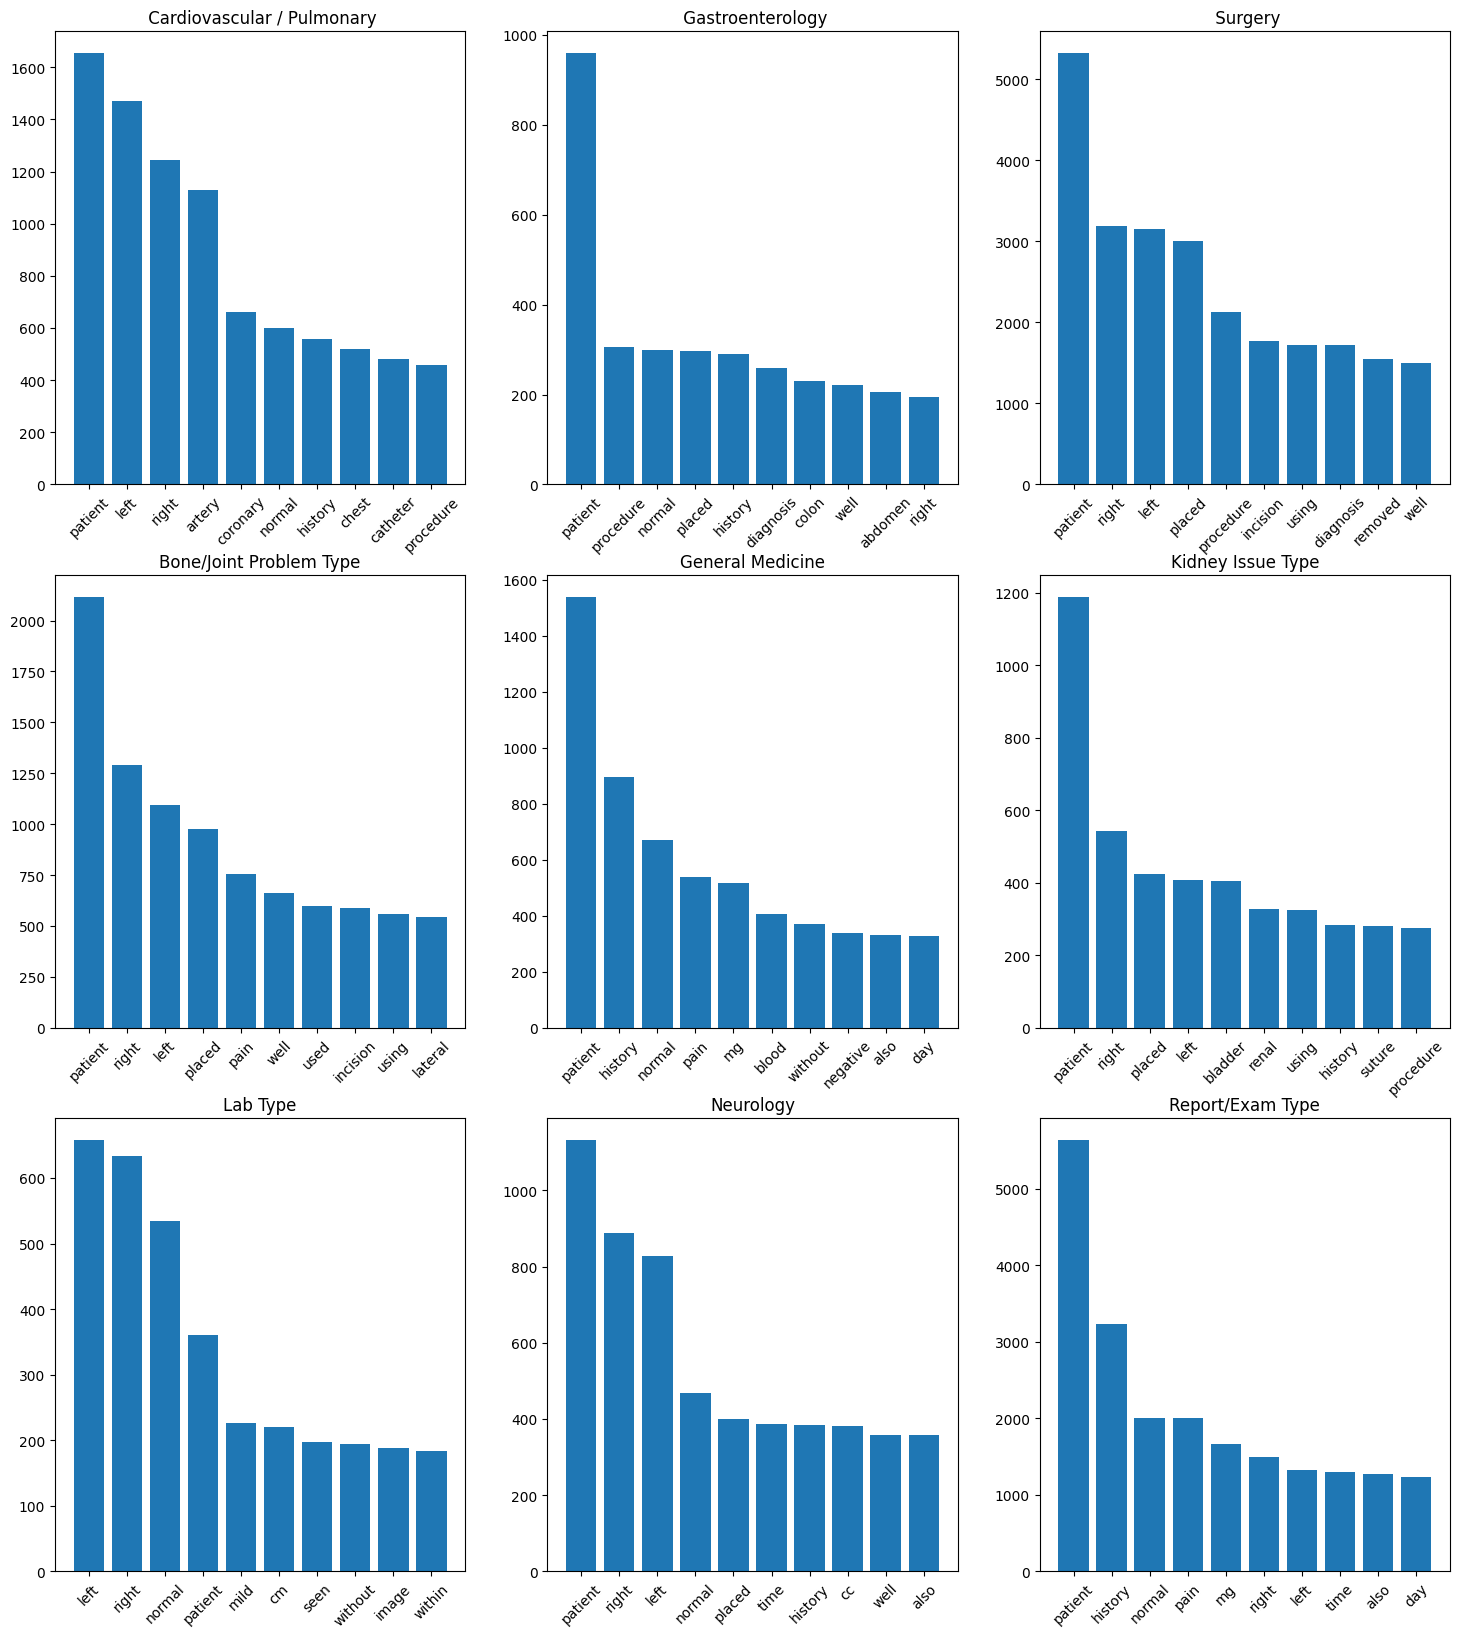

In [21]:
fig, axs=plt.subplots(3,3)
k, j=0, 0
for i in category.index:
   words=category["Transcription"][i].split()
   count=Counter(words)
   most_occur = count.most_common(10)
   x=[tag for tag, count in most_occur]
   y=[count for tag, count in most_occur]  
   fig.set_size_inches(18, 20)
   if j==0 or j==1:
     axs[k, j].bar(x, y)
     axs[k, j].set_title(category["target_variable"][i])
     axs[k, j].set_xticklabels(x, rotation = 45)
     j+=1
   else:
     axs[k, j].bar(x, y)
     axs[k, j].set_title(category["target_variable"][i])
     axs[k, j].set_xticklabels(x, rotation = 45)
     k+=1
     j=0

In [22]:
df_counts_100=df_counts_100[df_counts_100['target_variable']!='Report/Exam Type' ]
df_counts_100=df_counts_100[df_counts_100['target_variable']!=' Surgery' ]
df_counts_100=df_counts_100[df_counts_100['target_variable']!='Lab Type' ]
df_counts_100

,target_variable,Counts
11,Bone/Joint Problem Type,402
0,Cardiovascular / Pulmonary,371
16,Neurology,317
12,General Medicine,279
14,Kidney Issue Type,237
4,Gastroenterology,224


In [23]:
df_counts_100_merge=df_counts_100.merge(clinical_text_df, on='target_variable', how='left')
df_counts_200=df_counts_100_merge[['target_variable', 'cleaned transcription']]
df_counts_200

,target_variable,cleaned transcription
0,Bone/Joint Problem Type,preoperative diagnosis painful enlarged navicu...
1,Bone/Joint Problem Type,chief complaint yearold female present today c...
2,Bone/Joint Problem Type,exam three view right footreason exam right fo...
3,Bone/Joint Problem Type,preoperative diagnosis mass left second toe tu...
4,Bone/Joint Problem Type,exam three view right ankleindications painfin...
...,...,...
1825,Gastroenterology,preoperative diagnosis recurrent reinfected se...
1826,Gastroenterology,chief complaint nauseapresent illness patient ...
1827,Gastroenterology,preoperative diagnosis acute appendicitisposto...
1828,Gastroenterology,preoperative diagnosis abdominal wall abscessp...


# UPSAMPLING / DOWNSAMPLING

 Gastroenterology              400
Kidney Issue Type              400
General Medicine               400
Neurology                      400
 Cardiovascular / Pulmonary    400
Bone/Joint Problem Type        400
Name: target_variable, dtype: int64


<Axes: ylabel='Type'>

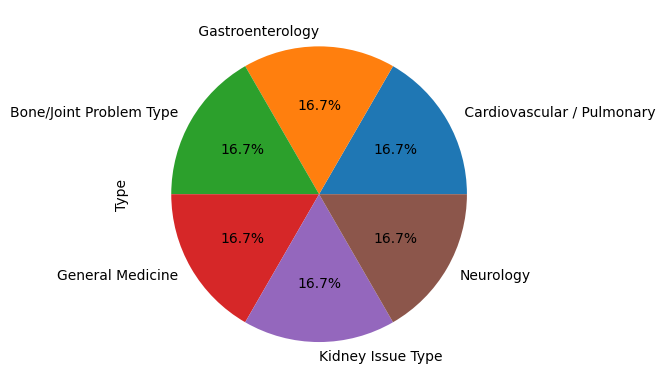

In [24]:
def sampling(df):
  cat_merge=df
  for cat in df['target_variable'].unique():
    cat_sample=resample(cat_merge[cat_merge['target_variable']==cat],
             replace=True,
             n_samples=400,
             random_state=42)
    cat_merge=pd.concat([cat_sample, cat_merge[cat_merge['target_variable']!=cat]])
    #print(cat_merge['target_variable'].value_counts())
  return cat_merge
data_downsampled=sampling(df_counts_200)
print(data_downsampled['target_variable'].value_counts())
data_downsampled.groupby('target_variable').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%')

# TSNE VISUALIZATION

In [25]:
vect=CountVectorizer()
X=vect.fit_transform(data_downsampled['cleaned transcription'])

In [26]:
X.shape

(2400, 22787)

In [27]:
# Run for loop of different perplexities to find best value, which is 50

# list_ = [30, 50,100, 120, 150, 160]
# for i in list_:
#   tsne=TSNE(n_components=2, verbose=1, random_state=42, learning_rate=0.15, init="pca", perplexity=i).fit_transform(X.toarray())
#   fig = px.scatter(x=tsne[:,0],y=tsne[:,1], color=data_downsampled['target_variable'], labels={'color':'Target Variable'})
#   print(f"Perplexity: {i}")
#   fig.show()

tsne=TSNE(n_components=2, verbose=1, random_state=42, learning_rate=0.15, init="pca", perplexity=50).fit_transform(X.toarray())
fig = px.scatter(x=tsne[:,0],y=tsne[:,1], color=data_downsampled['target_variable'], labels={'color':'Target Variable'})
fig.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2400 samples in 0.020s...
[t-SNE] Computed neighbors for 2400 samples in 9.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2400
[t-SNE] Computed conditional probabilities for sample 2000 / 2400
[t-SNE] Computed conditional probabilities for sample 2400 / 2400
[t-SNE] Mean sigma: 6.985151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.970642
[t-SNE] KL divergence after 1000 iterations: 2.278675


In [28]:
tsne.shape

(2400, 2)

# N-GRAM SPLIT

In [29]:
def n_gram(data_downsampled,n_gram):
  vectorizer = TfidfVectorizer(ngram_range = (n_gram,n_gram))
  X = vectorizer.fit_transform(data_downsampled['cleaned transcription'])
  return X

In [30]:
'''
X1 : unigram
X2 : bigram
X3 : trigram
'''
X1=n_gram(data_downsampled,1)
X2=n_gram(data_downsampled,2)
X3=n_gram(data_downsampled,3)

In [31]:
X1.shape, X2.shape , X3.shape

((2400, 22787), (2400, 174340), (2400, 248025))

# TRAIN / TEST SPLIT

In [32]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, data_downsampled['target_variable'], test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, data_downsampled['target_variable'], test_size=0.2, random_state=42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, data_downsampled['target_variable'], test_size=0.2, random_state=42)

# MULTINOMIAL NAIVE BAYES

In [33]:
def multinomial(X_train, y_train, X_test, y_test):
  model=MultinomialNB(alpha=0.003)
  model.fit(X_train, y_train)
  X_predict=model.predict(X_test)
  class_=classification_report(y_test,X_predict, output_dict=True)
  nb = pd.DataFrame(class_).transpose()
  return nb

## MULTINOMIAL NB - TRIGRAM CLASSIFICATION REPORT

In [34]:
tri_nb = multinomial(X3_train, y3_train, X3_test, y3_test)
tri_nb

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.932432,0.896104,0.913907,77.000000
Gastroenterology,0.824176,0.937500,0.877193,80.000000
Bone/Joint Problem Type,0.831325,0.862500,0.846626,80.000000
General Medicine,0.907895,0.862500,0.884615,80.000000
Kidney Issue Type,0.821053,0.886364,0.852459,88.000000
Neurology,0.901639,0.733333,0.808824,75.000000
accuracy,0.864583,0.864583,0.864583,0.864583
macro avg,0.869753,0.863050,0.863937,480.000000
weighted avg,0.868218,0.864583,0.864008,480.000000


## MULTINOMIAL NB - BIGRAM CLASSIFICATION REPORT

In [35]:
bi_nb = multinomial(X2_train, y2_train, X2_test, y2_test)
bi_nb

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.958333,0.896104,0.926174,77.000000
Gastroenterology,0.901235,0.912500,0.906832,80.000000
Bone/Joint Problem Type,0.825581,0.887500,0.855422,80.000000
General Medicine,0.822222,0.925000,0.870588,80.000000
Kidney Issue Type,0.916667,0.875000,0.895349,88.000000
Neurology,0.865672,0.773333,0.816901,75.000000
accuracy,0.879167,0.879167,0.879167,0.879167
macro avg,0.881618,0.878240,0.878544,480.000000
weighted avg,0.881889,0.879167,0.879169,480.000000


## MULTINOMIAL NB - UNIGRAM CLASSIFICATION REPORT

In [36]:
uni_nb = multinomial(X1_train, y1_train, X1_test, y1_test)
uni_nb

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.916667,0.857143,0.885906,77.000000
Gastroenterology,0.887500,0.887500,0.887500,80.000000
Bone/Joint Problem Type,0.837209,0.900000,0.867470,80.000000
General Medicine,0.760417,0.912500,0.829545,80.000000
Kidney Issue Type,0.950617,0.875000,0.911243,88.000000
Neurology,0.907692,0.786667,0.842857,75.000000
accuracy,0.870833,0.870833,0.870833,0.870833
macro avg,0.876684,0.869802,0.870754,480.000000
weighted avg,0.877343,0.870833,0.871624,480.000000


## MULTINOMIAL NB - F-1 SCORE COMPARISON

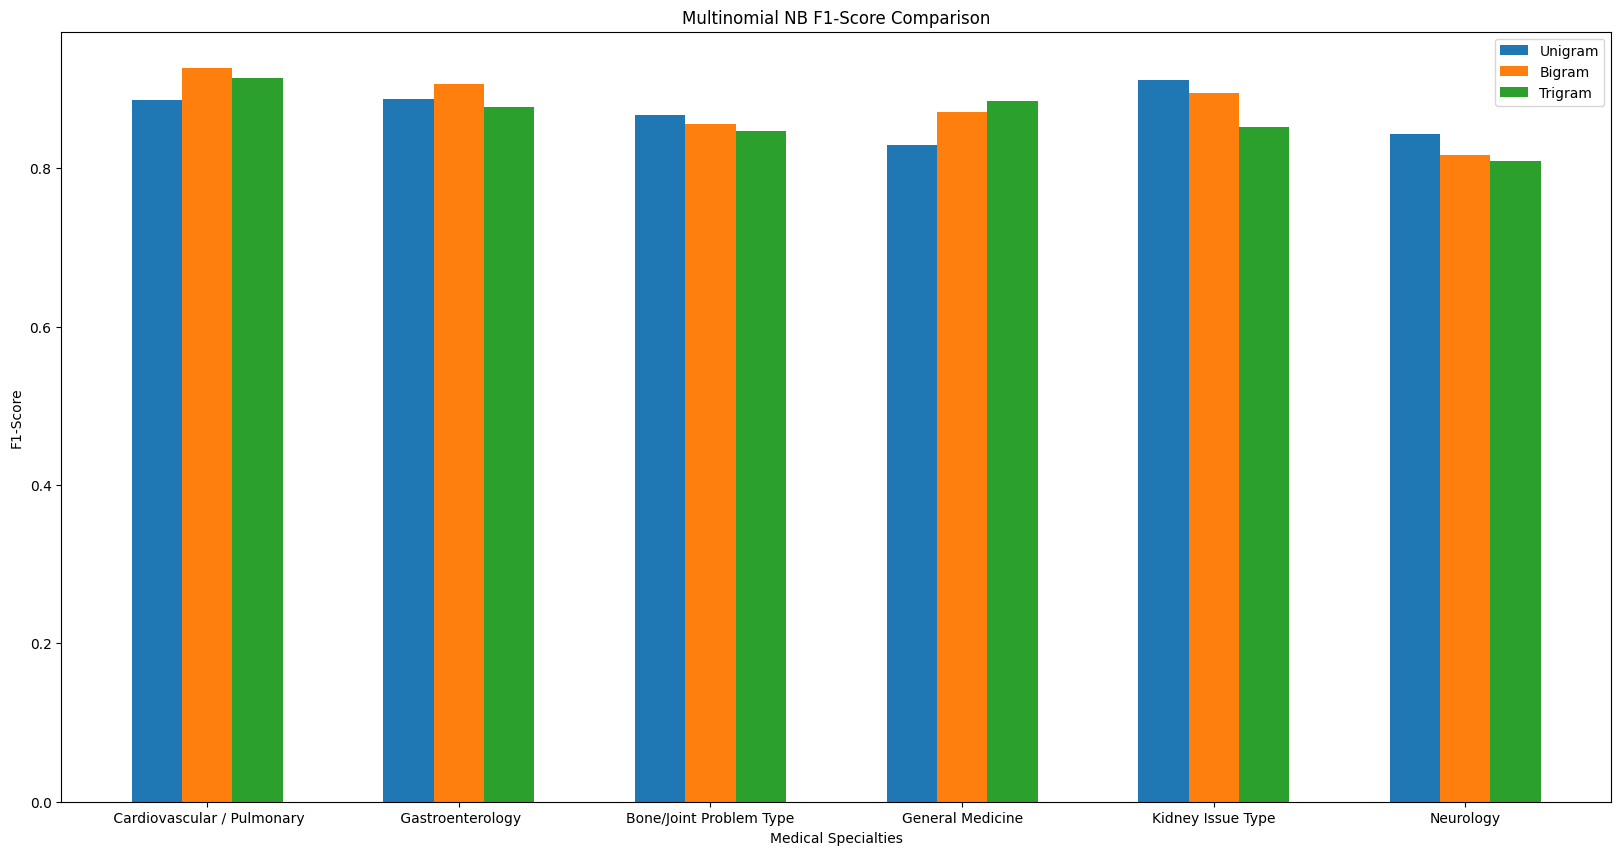

In [37]:
X = list(uni_nb.index[0:6])
Y_uni = list(uni_nb[0:6]['f1-score'])
Y_bi = list(bi_nb[0:6]['f1-score'])
Y_tri = list(tri_nb[0:6]['f1-score'])
  
X_axis = np.arange(len(X))
  
plt.figure(figsize=(20,10)) 
plt.bar(X_axis - 0.2, Y_uni, label = 'Unigram', width=0.2)
plt.bar(X_axis, Y_bi, label = 'Bigram', width=0.2)
plt.bar(X_axis + 0.2, Y_tri, label = 'Trigram', width=0.2)


plt.xticks(X_axis, X)
plt.xlabel("Medical Specialties")
plt.ylabel("F1-Score")
plt.title("Multinomial NB F1-Score Comparison")
plt.legend()

plt.show()

# KNN 

In [38]:
def knn(X_train, y_train, X_test, y_test):
  knn = KNeighborsClassifier()
  knn.fit(X_train.toarray(), y_train)
  X_predict = knn.predict(X_test.toarray())
  class_=classification_report(y_test,X_predict, output_dict=True)
  knn = pd.DataFrame(class_).transpose()
  return knn

## KNN - TRIGRAM CLASSIFICATION REPORT

In [39]:
tri_knn = knn(X3_train, y3_train, X3_test, y3_test)
tri_knn

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.547170,0.376623,0.446154,77.000
Gastroenterology,0.927536,0.800000,0.859060,80.000
Bone/Joint Problem Type,0.287823,0.975000,0.444444,80.000
General Medicine,0.913043,0.262500,0.407767,80.000
Kidney Issue Type,0.925000,0.420455,0.578125,88.000
Neurology,0.958333,0.306667,0.464646,75.000
accuracy,0.525000,0.525000,0.525000,0.525
macro avg,0.759818,0.523541,0.533366,480.000
weighted avg,0.761832,0.525000,0.535373,480.000


## KNN - BIGRAM CLASSIFICATION REPORT

In [40]:
bi_knn = knn(X2_train, y2_train, X2_test, y2_test)
bi_knn

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.231707,0.987013,0.375309,77.000000
Gastroenterology,0.911111,0.512500,0.656000,80.000000
Bone/Joint Problem Type,0.608696,0.175000,0.271845,80.000000
General Medicine,0.933333,0.350000,0.509091,80.000000
Kidney Issue Type,0.933333,0.318182,0.474576,88.000000
Neurology,0.916667,0.293333,0.444444,75.000000
accuracy,0.435417,0.435417,0.435417,0.435417
macro avg,0.755808,0.439338,0.455211,480.000000
weighted avg,0.760367,0.435417,0.456145,480.000000


## KNN - UNIGRAM CLASSIFICATION REPORT

In [41]:
uni_knn = knn(X1_train, y1_train, X1_test, y1_test)
uni_knn

,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.741935,0.896104,0.811765,77.000000
Gastroenterology,0.788889,0.887500,0.835294,80.000000
Bone/Joint Problem Type,0.825581,0.887500,0.855422,80.000000
General Medicine,0.796875,0.637500,0.708333,80.000000
Kidney Issue Type,0.870588,0.840909,0.855491,88.000000
Neurology,0.854839,0.706667,0.773723,75.000000
accuracy,0.810417,0.810417,0.810417,0.810417
macro avg,0.813118,0.809363,0.806671,480.000000
weighted avg,0.814086,0.810417,0.807796,480.000000


## KNN - F1-SCORE COMPARISON

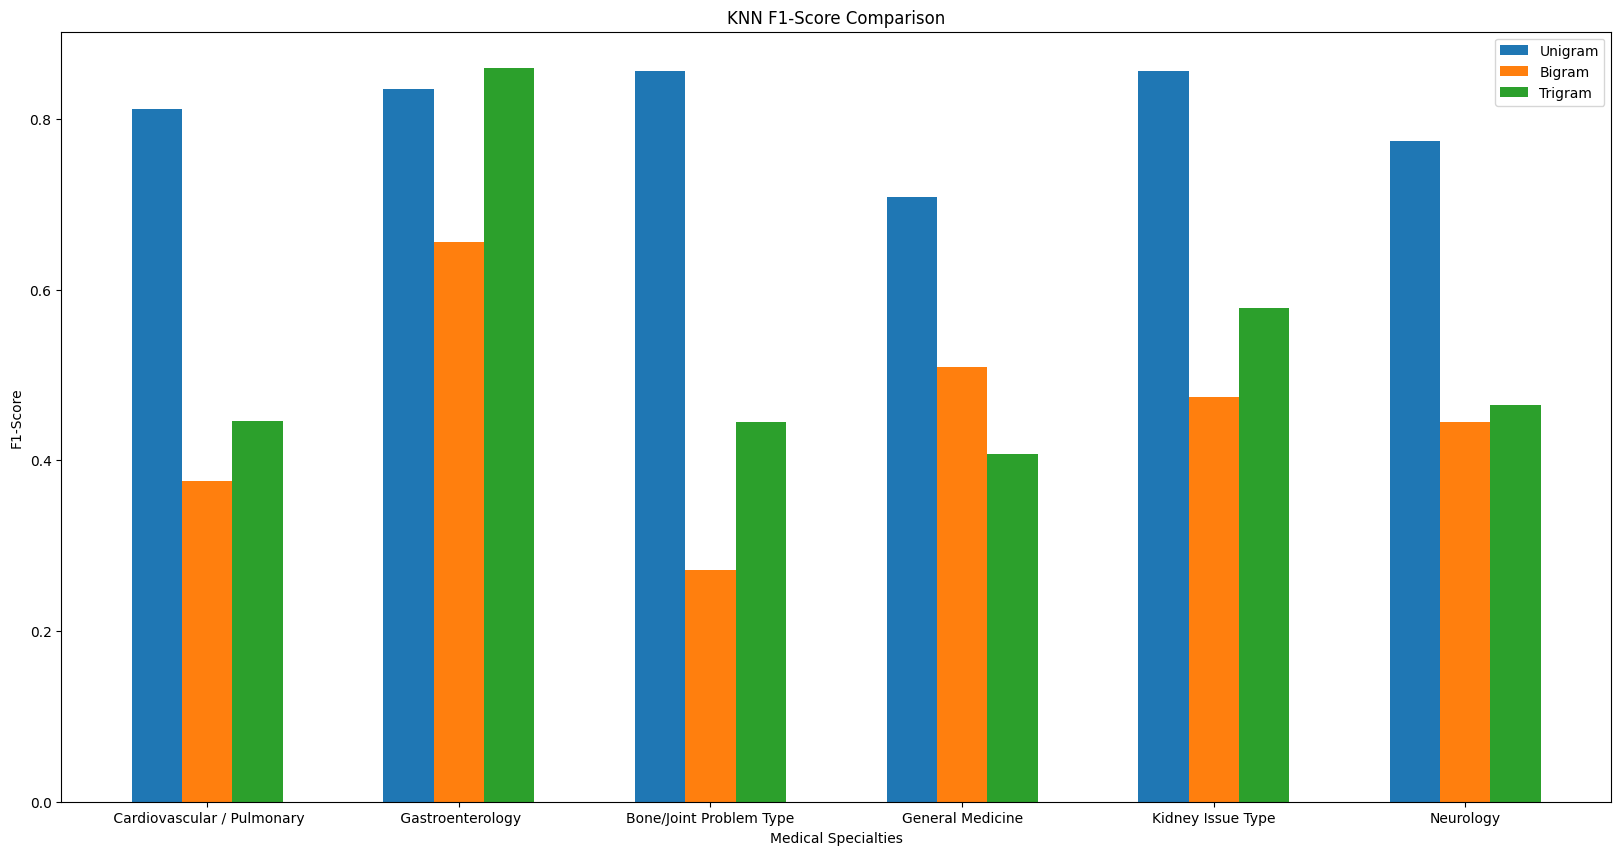

In [42]:
X = list(uni_knn.index[0:6])
Y_uni = list(uni_knn[0:6]['f1-score'])
Y_bi = list(bi_knn[0:6]['f1-score'])
Y_tri = list(tri_knn[0:6]['f1-score'])
  
X_axis = np.arange(len(X))
  
plt.figure(figsize=(20,10)) 
plt.bar(X_axis - 0.2, Y_uni, label = 'Unigram', width=0.2)
plt.bar(X_axis, Y_bi, label = 'Bigram', width=0.2)
plt.bar(X_axis + 0.2, Y_tri, label = 'Trigram', width=0.2)


plt.xticks(X_axis, X)
plt.xlabel("Medical Specialties")
plt.ylabel("F1-Score")
plt.title("KNN F1-Score Comparison")
plt.legend()

plt.show()

# DECISION TREE

In [43]:
def decision_tree(X_train, y_train, X_test, y_test):
  f1=0
  for i in range(20):
    param_dist = {
        "max_features": randint(1,9),
        "min_samples_leaf": randint(1,9)}
    tree1 = tree.DecisionTreeClassifier()
    tree_cv = RandomizedSearchCV(tree1, param_dist, cv=5)
    tree_cv.fit(X_train, y_train)
    X_pred = tree_cv.predict(X_test)
    f1_new = f1_score(y_test, X_pred, average = "weighted")
    if f1 < f1_new:
      f1 = f1_new
      X_predict = X_pred
      best_params=tree_cv.best_params_
  print("Decision Tree Parameters: ", best_params)
  class_ = classification_report(y_test, X_predict, output_dict=True)
  decision = pd.DataFrame(class_).transpose()
  return decision

## DECISION TREE - UNIGRAM CLASSIFICATION REPORT

In [44]:
uni_decision = decision_tree(X1_train, y1_train, X1_test, y1_test)
uni_decision

Decision Tree Parameters:  {'max_features': 6, 'min_samples_leaf': 1}


,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.863636,0.740260,0.797203,77.000000
Gastroenterology,0.795455,0.875000,0.833333,80.000000
Bone/Joint Problem Type,0.681319,0.775000,0.725146,80.000000
General Medicine,0.844156,0.812500,0.828025,80.000000
Kidney Issue Type,0.783505,0.863636,0.821622,88.000000
Neurology,0.852459,0.693333,0.764706,75.000000
accuracy,0.795833,0.795833,0.795833,0.795833
macro avg,0.803422,0.793288,0.795006,480.000000
weighted avg,0.802203,0.795833,0.795751,480.000000


## DECISION TREE - BIGRAM CLASSIFICATION REPORT 



In [45]:
bi_decision = decision_tree(X2_train, y2_train, X2_test, y2_test)
bi_decision

Decision Tree Parameters:  {'max_features': 8, 'min_samples_leaf': 1}


,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.660194,0.883117,0.755556,77.000000
Gastroenterology,0.775281,0.862500,0.816568,80.000000
Bone/Joint Problem Type,0.813333,0.762500,0.787097,80.000000
General Medicine,0.890625,0.712500,0.791667,80.000000
Kidney Issue Type,0.843373,0.795455,0.818713,88.000000
Neurology,0.787879,0.693333,0.737589,75.000000
accuracy,0.785417,0.785417,0.785417,0.785417
macro avg,0.795114,0.784901,0.784532,480.000000
weighted avg,0.796837,0.785417,0.785771,480.000000


## DECISION TREE - TRIGRAM CLASSIFICATION REPORT 

In [46]:
tri_decision = decision_tree(X3_train, y3_train, X3_test, y3_test)
tri_decision

Decision Tree Parameters:  {'max_features': 3, 'min_samples_leaf': 1}


,precision,recall,f1-score,support
Cardiovascular / Pulmonary,0.927273,0.662338,0.772727,77.00000
Gastroenterology,0.841463,0.862500,0.851852,80.00000
Bone/Joint Problem Type,0.496454,0.875000,0.633484,80.00000
General Medicine,0.875000,0.700000,0.777778,80.00000
Kidney Issue Type,0.879518,0.829545,0.853801,88.00000
Neurology,0.909091,0.666667,0.769231,75.00000
accuracy,0.768750,0.768750,0.768750,0.76875
macro avg,0.821467,0.766008,0.776479,480.00000
weighted avg,0.820860,0.768750,0.777866,480.00000


## DECISION TREE - F1-SCORE COMPARISON

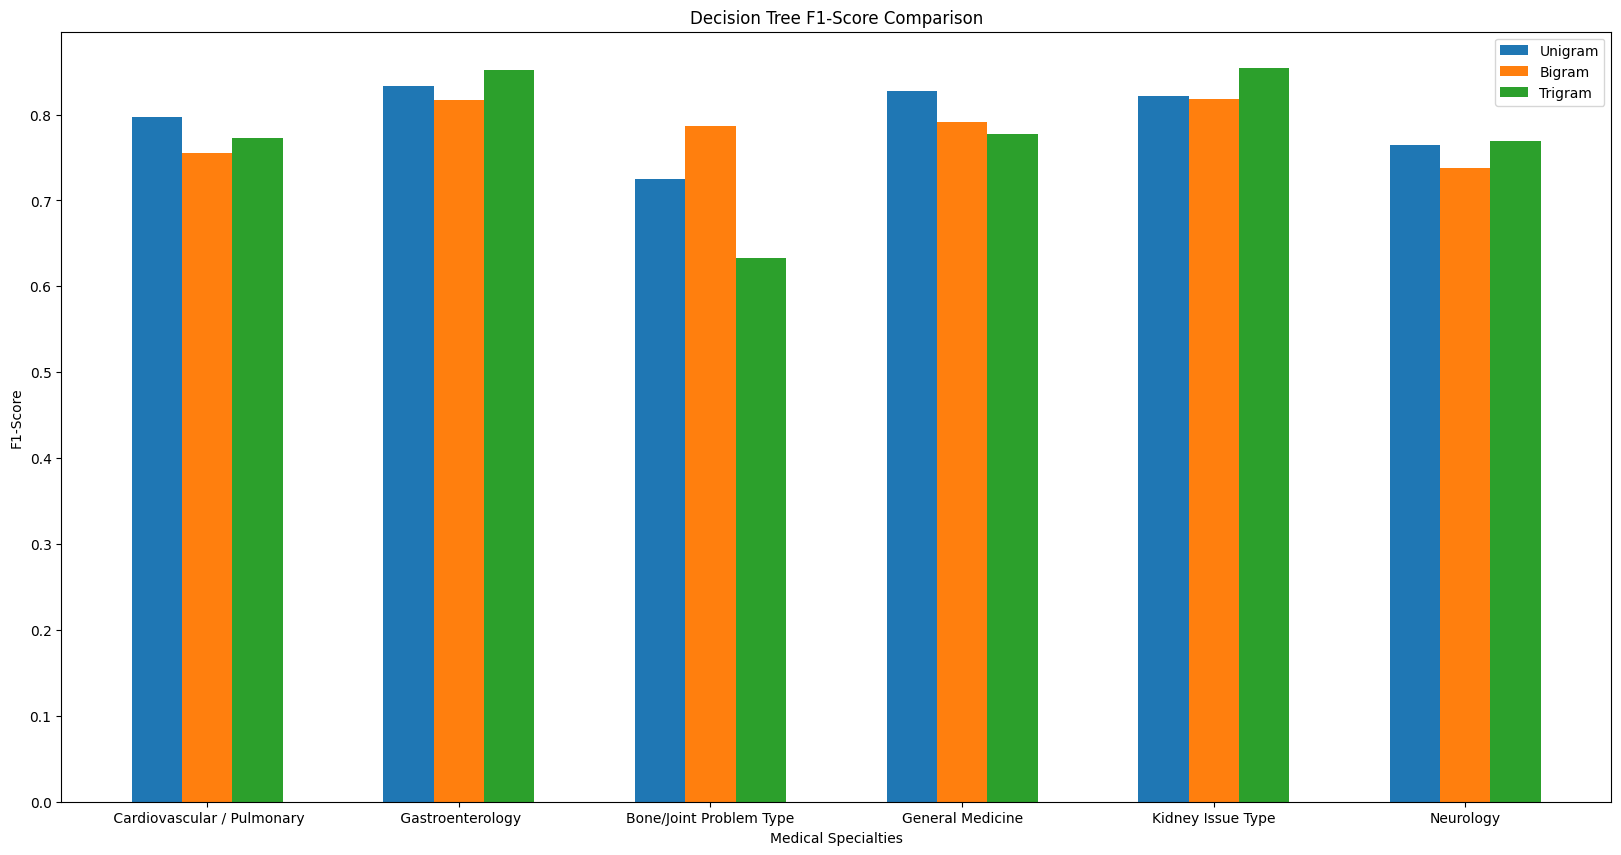

In [47]:
X = list(uni_decision.index[0:6])
Y_uni = list(uni_decision[0:6]['f1-score'])
Y_bi = list(bi_decision[0:6]['f1-score'])
Y_tri = list(tri_decision[0:6]['f1-score'])
  
X_axis = np.arange(len(X))
  
plt.figure(figsize=(20,10)) 
plt.bar(X_axis - 0.2, Y_uni, label = 'Unigram', width=0.2)
plt.bar(X_axis, Y_bi, label = 'Bigram', width=0.2)
plt.bar(X_axis + 0.2, Y_tri, label = 'Trigram', width=0.2)


plt.xticks(X_axis, X)
plt.xlabel("Medical Specialties")
plt.ylabel("F1-Score")
plt.title("Decision Tree F1-Score Comparison")
plt.legend()

plt.show()

# LSTM

In [48]:
#One Hot Encoding of the Labels
le = preprocessing.LabelEncoder()
ye=data_downsampled['target_variable'].unique()
y=le.fit_transform(ye)
y=y.reshape(-1,1)
on=OneHotEncoder(sparse=False)
y=on.fit_transform(data_downsampled[['target_variable']])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



## TRAIN / TEST SPLIT

In [49]:
x_train, x_test, y_train, y_test = train_test_split(data_downsampled['cleaned transcription'], y, test_size=0.2, random_state=42)

In [50]:
#Parameters Initialization
max_len =200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' 
vocab_size = 1000
embedding_dim = 16
input_shape=x_train.shape
n_lstm = 64
drop_lstm = 0.4

In [51]:
#Tokenizing the training samples
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [52]:
#Padding the training samples
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [53]:
#Padding and Tokenizing the test samples 
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len ,
                               padding = padding_type,
                               truncating = trunc_type)

## MODEL ARCHITECTURE

In [54]:
def build_model():
  model2 = Sequential()
  model2.add(Embedding(input_dim=input_shape[0],
                      output_dim=128,
                      input_length=max_len))
  model2.add(Bidirectional(LSTM(n_lstm,dropout=drop_lstm),input_shape=(128,1,32)))
  model2.add(Dense(32, activation='relu'))
  model2.add(Dropout(drop_lstm))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dropout(drop_lstm))
  model2.add(Dense(6, activation='softmax'))
  model2.compile(loss = "categorical_crossentropy",
               optimizer = 'adam',
               metrics=['accuracy'])
  return model2

In [55]:
model2=build_model()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          245760    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [56]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(training_padded,
                     np.array(y_train),
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
60/60 - 20s - loss: 1.7868 - accuracy: 0.1937 - val_loss: 1.7587 - val_accuracy: 0.2875 - 20s/epoch - 335ms/step
Epoch 2/30
60/60 - 4s - loss: 1.6822 - accuracy: 0.3187 - val_loss: 1.4662 - val_accuracy: 0.4792 - 4s/epoch - 61ms/step
Epoch 3/30
60/60 - 4s - loss: 1.3016 - accuracy: 0.4812 - val_loss: 0.9992 - val_accuracy: 0.6187 - 4s/epoch - 65ms/step
Epoch 4/30
60/60 - 3s - loss: 0.9332 - accuracy: 0.6161 - val_loss: 0.7606 - val_accuracy: 0.7437 - 3s/epoch - 53ms/step
Epoch 5/30
60/60 - 2s - loss: 0.7216 - accuracy: 0.7312 - val_loss: 0.6482 - val_accuracy: 0.7750 - 2s/epoch - 32ms/step
Epoch 6/30
60/60 - 2s - loss: 0.6124 - accuracy: 0.7693 - val_loss: 0.8781 - val_accuracy: 0.7333 - 2s/epoch - 27ms/step
Epoch 7/30
60/60 - 1s - loss: 0.5300 - accuracy: 0.8292 - val_loss: 0.5284 - val_accuracy: 0.8438 - 929ms/epoch - 15ms/step
Epoch 8/30
60/60 - 1s - loss: 0.4324 - accuracy: 0.8562 - val_loss: 0.5584 - val_accuracy: 0.8396 - 1s/epoch - 18ms/step
Epoch 9/30
60/60 - 1s - lo

In [57]:
pred=model2.predict(testing_padded)
predict_classes=np.argmax(pred,axis=-1)
pred_encoded=on.fit_transform(predict_classes.reshape(-1,1))
class_=classification_report(pred_encoded, y_test, output_dict = True)
lstm = pd.DataFrame(class_).transpose()
lstm

15/15 [==============================] - 1s 9ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,precision,recall,f1-score,support
0,0.870130,0.905405,0.887417,74.0
1,0.887500,0.898734,0.893082,79.0
2,0.837500,0.797619,0.817073,84.0
3,0.850000,0.755556,0.800000,90.0
4,0.875000,0.846154,0.860335,91.0
5,0.706667,0.854839,0.773723,62.0
micro avg,0.839583,0.839583,0.839583,480.0
macro avg,0.837799,0.843051,0.838605,480.0
weighted avg,0.843313,0.839583,0.839829,480.0
samples avg,0.839583,0.839583,0.839583,480.0


# MODEL ACCURACY COMPARISON

In [58]:
model_result = pd.DataFrame({'KNN-unigram': uni_knn['precision']['accuracy'], 
                             'KNN-bigram': bi_knn['precision']['accuracy'], 
                             'KNN-trigram': tri_knn['precision']['accuracy'], 
                             'DT-unigram': uni_decision['precision']['accuracy'], 
                             'DT-bigram': bi_decision['precision']['accuracy'], 
                             'DT-trigram': tri_decision['precision']['accuracy'],  
                             'NB-unigram': uni_nb['precision']['accuracy'],
                             'NB-bigram': bi_nb['precision']['accuracy'], 
                             'NB-trigram': tri_nb['precision']['accuracy'],
                             'LSTM': lstm['precision']['weighted avg']},
                             index=[0])
model_result=model_result.transpose().rename(columns={0: 'Accuracy'})
model_result

,Accuracy
KNN-unigram,0.810417
KNN-bigram,0.435417
KNN-trigram,0.525000
DT-unigram,0.795833
DT-bigram,0.785417
DT-trigram,0.768750
NB-unigram,0.870833
NB-bigram,0.879167
NB-trigram,0.864583
LSTM,0.843313


## MODELS RANKED BY ACCURACY

In [59]:
model_sorted=model_result.sort_values(by=['Accuracy'], ascending=False)
model_sorted

,Accuracy
NB-bigram,0.879167
NB-unigram,0.870833
NB-trigram,0.864583
LSTM,0.843313
KNN-unigram,0.810417
DT-unigram,0.795833
DT-bigram,0.785417
DT-trigram,0.768750
KNN-trigram,0.525000
KNN-bigram,0.435417


## OVERALL MODEL COMPARISON

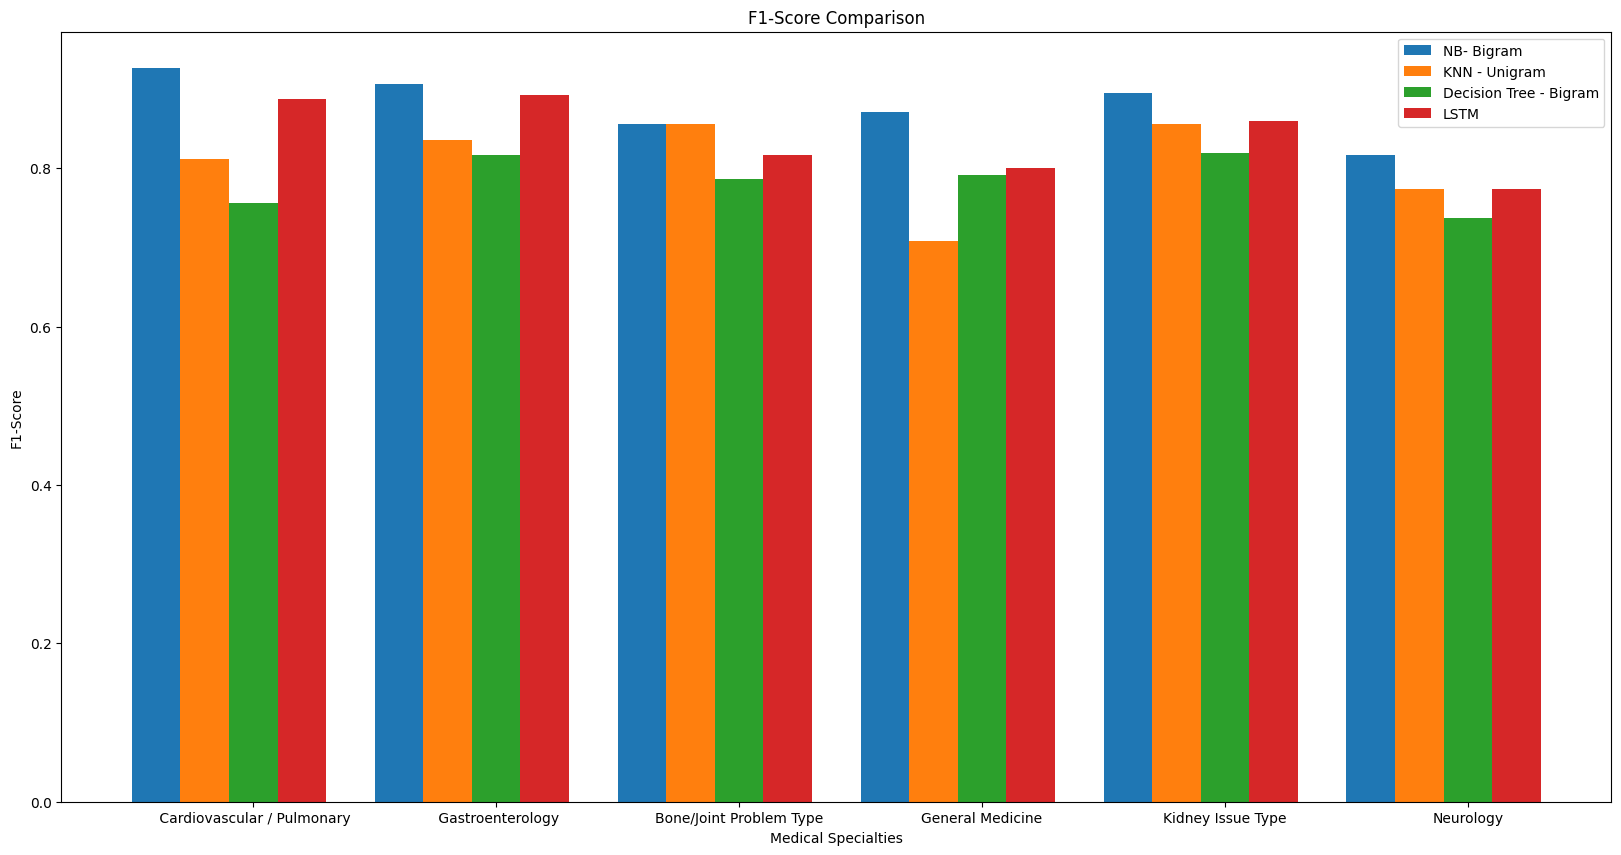

In [60]:
X = list(uni_decision.index[0:6])
Y_nb = list(bi_nb[0:6]['f1-score'])
Y_knn = list(uni_knn[0:6]['f1-score'])
Y_dt = list(bi_decision[0:6]['f1-score'])
Y_lstm = list(lstm[0:6]['f1-score'])


X_axis = np.arange(len(X))
  
plt.figure(figsize=(20,10)) 
plt.bar(X_axis - 0.4, Y_nb, label = 'NB- Bigram', width=0.2)
plt.bar(X_axis - 0.2, Y_knn, label = 'KNN - Unigram', width=0.2)
plt.bar(X_axis + 0, Y_dt, label = 'Decision Tree - Bigram', width=0.2)
plt.bar(X_axis + 0.2, Y_lstm, label = 'LSTM', width=0.2)


plt.xticks(X_axis, X)
plt.xlabel("Medical Specialties")
plt.ylabel("F1-Score")
plt.title("F1-Score Comparison")
plt.legend()

plt.show()